# Loading Dataset

In [1]:
import numpy as np
import pandas as pd

# Setting seed for reproducibility
np.random.seed(42)

# Number of samples
n_samples = 1000

# Simulating features
age = np.random.randint(65, 95, size=n_samples)
walking_speed = np.clip(np.random.normal(loc=1.0, scale=0.3, size=n_samples), 0.2, 2.0)  # m/s
missed_meals = np.random.poisson(lam=1.5, size=n_samples)  # meals missed per week
sleep_hours = np.clip(np.random.normal(loc=6.5, scale=1.5, size=n_samples), 3, 10)
med_adherence = np.random.binomial(1, 0.8, size=n_samples)  # 1 = adherent
past_falls = np.random.poisson(lam=0.7, size=n_samples)
mobility_aid = np.random.binomial(1, 0.4, size=n_samples)  # 1 = uses aid

# Creating fall risk using rule-based logic
risk_score = (
    (age > 80).astype(int) +
    (walking_speed < 0.8).astype(int) +
    (missed_meals > 2).astype(int) +
    (sleep_hours < 5.5).astype(int) +
    (med_adherence == 0).astype(int) +
    (past_falls > 1).astype(int) +
    (mobility_aid == 1).astype(int)
)

# Label generation based on risk score
fall_risk = (risk_score >= 3).astype(int)

# Combining into a DataFrame
df = pd.DataFrame({
    "Age": age,
    "WalkingSpeed": walking_speed,
    "MissedMeals": missed_meals,
    "SleepHours": sleep_hours,
    "MedicationAdherence": med_adherence,
    "PastFalls": past_falls,
    "MobilityAid": mobility_aid,
    "FallRisk": fall_risk
})

# Preview
print(df.head())


   Age  WalkingSpeed  MissedMeals  SleepHours  MedicationAdherence  PastFalls  \
0   71      0.906093            1    5.615136                    1          0   
1   84      0.520263            0    7.766425                    1          2   
2   93      0.589423            3    6.237583                    1          1   
3   79      1.160648            0    4.895157                    1          1   
4   75      1.318134            3    4.602970                    1          0   

   MobilityAid  FallRisk  
0            1         0  
1            1         1  
2            0         1  
3            1         0  
4            1         1  


# Importing Required Libraries

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Dataset Overview

In [3]:
# Show basic info
df.info()

# Check for missing values
print("\nMissing values:\n", df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  1000 non-null   int64  
 1   WalkingSpeed         1000 non-null   float64
 2   MissedMeals          1000 non-null   int64  
 3   SleepHours           1000 non-null   float64
 4   MedicationAdherence  1000 non-null   int64  
 5   PastFalls            1000 non-null   int64  
 6   MobilityAid          1000 non-null   int64  
 7   FallRisk             1000 non-null   int64  
dtypes: float64(2), int64(6)
memory usage: 62.6 KB

Missing values:
 Age                    0
WalkingSpeed           0
MissedMeals            0
SleepHours             0
MedicationAdherence    0
PastFalls              0
MobilityAid            0
FallRisk               0
dtype: int64


# Descriptive Statistics


In [4]:
# Basic stats
df.describe()


,Age,WalkingSpeed,MissedMeals,SleepHours,MedicationAdherence,PastFalls,MobilityAid,FallRisk
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,79.940000,0.992489,1.510000,6.472612,0.797000,0.64000,0.375000,0.287000
std,9.033493,0.298021,1.243159,1.471938,0.402434,0.77395,0.484365,0.452588
min,65.000000,0.200000,0.000000,3.000000,0.000000,0.00000,0.000000,0.000000
25%,72.000000,0.789541,1.000000,5.486119,1.000000,0.00000,0.000000,0.000000
50%,80.000000,0.995649,1.000000,6.413826,1.000000,0.00000,0.000000,0.000000
75%,88.000000,1.189089,2.000000,7.477040,1.000000,1.00000,1.000000,1.000000
max,94.000000,1.889503,7.000000,10.000000,1.000000,4.00000,1.000000,1.000000


# Visualizing Feature Distributions

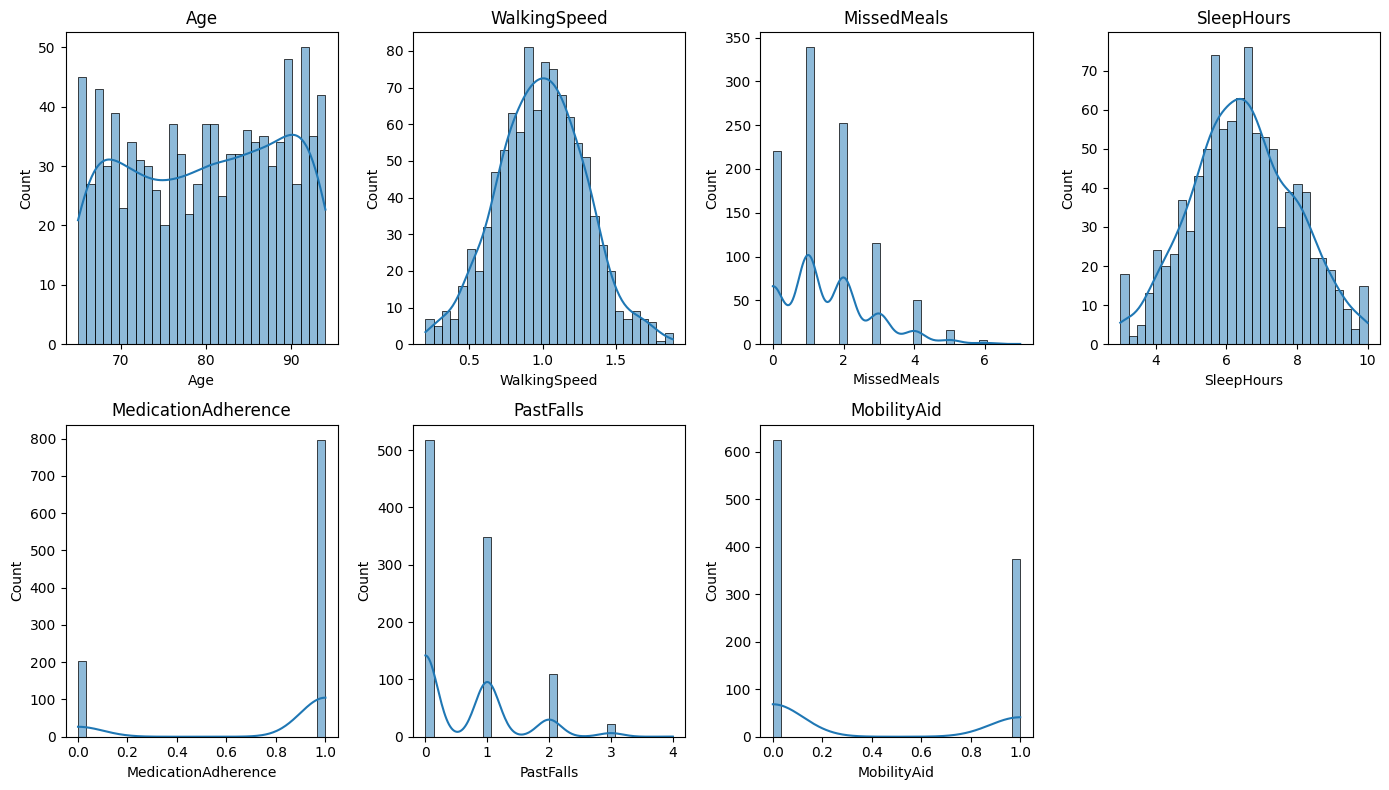

In [5]:
plt.figure(figsize=(14, 8))
for idx, col in enumerate(df.columns[:-1]):
    plt.subplot(2, 4, idx+1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"{col}")
plt.tight_layout()
plt.show()


# Correlation Heatmap

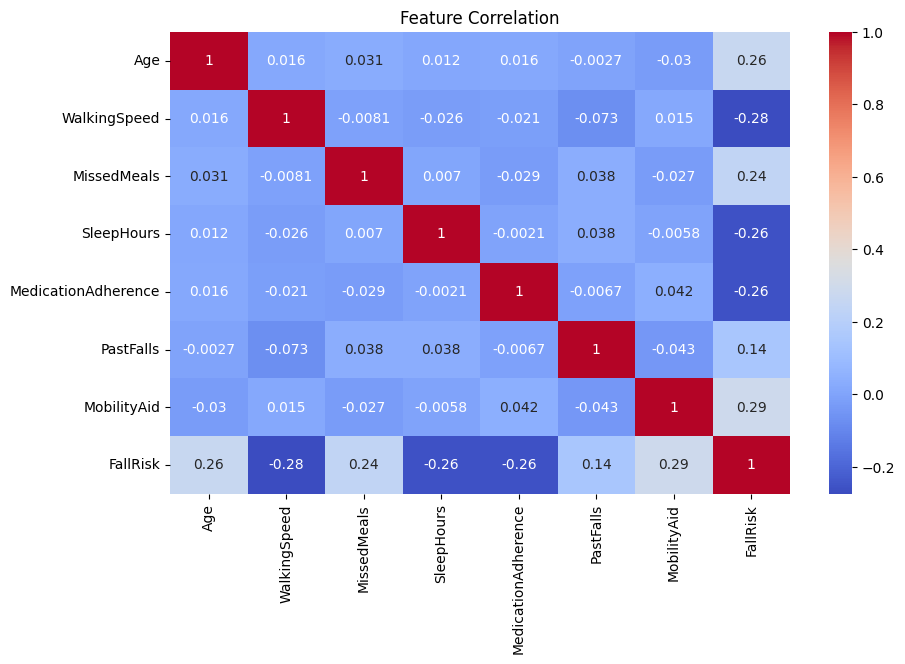

In [6]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation")
plt.show()


# FallRisk Distribution

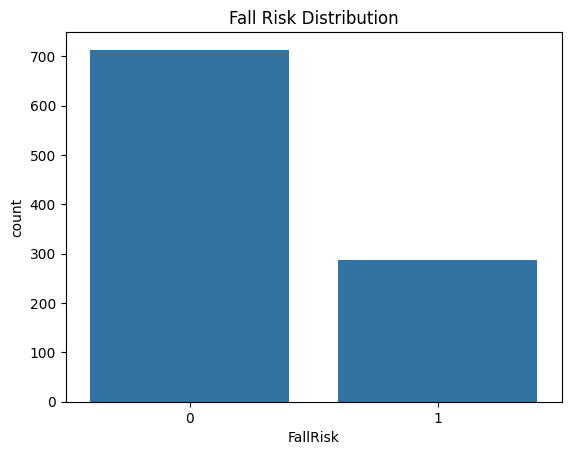

In [7]:
sns.countplot(data=df, x='FallRisk')
plt.title("Fall Risk Distribution")
plt.show()


# Preprocessing – Train/Test Split & Scaling

In [8]:
# Features and target
X = df.drop("FallRisk", axis=1)
y = df["FallRisk"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


#Model Training with XGBoost + Hyperparameter Tuning using Optuna

## Install & Import Libraries


In [9]:
!pip install xgboost optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 15.8 MB/s eta 0:00:00


In [10]:
import xgboost as xgb
import optuna
from sklearn.metrics import accuracy_score, classification_report


## Define Objective Function for Optuna

In [11]:
def objective(trial):
    # XGBoost hyperparameters to optimize
    param = {
        'objective': 'binary:logistic', # binary classification
        'eval_metric': 'logloss', # evaluation metric
        'eta': trial.suggest_loguniform('eta', 0.01, 0.2),  # learning rate
        'max_depth': trial.suggest_int('max_depth', 3, 12),  # max depth of tree
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  # min child weight
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),  # subsample ratio
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),  # column sample ratio
        'n_estimators': 1000  # set a fixed number of trees
    }

    # Create and train the model
    model = xgb.XGBClassifier(**param, use_label_encoder=False)
    model.fit(X_train_scaled, y_train)

    # Prediction and accuracy
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy


## Hyperparameter Tuning with Optuna


In [12]:
# Running Optuna optimization
study = optuna.create_study(direction='maximize')  # maximize accuracy
study.optimize(objective, n_trials=50)  # Number of trials

# Best hyperparameters found
print("Best hyperparameters: ", study.best_params)


[I 2025-05-06 10:36:48,168] A new study created in memory with name: no-name-2a793660-ad46-4daf-86c7-89913e41f61b
<ipython-input-11-f5b558b12222>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 0.01, 0.2),  # learning rate
<ipython-input-11-f5b558b12222>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),  # subsample ratio
<ipython-input-11-f5b558b12222>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsam

Best hyperparameters:  {'eta': 0.03469660864024855, 'max_depth': 12, 'min_child_weight': 6, 'subsample': 0.7853293633667682, 'colsample_bytree': 0.7087983019554912}


##Training the Final Model

In [13]:
# Using the best hyperparameters
best_params = study.best_params

model = xgb.XGBClassifier(**best_params, use_label_encoder=False, n_estimators=1000)
model.fit(X_train_scaled, y_train)

# Prediction and Evaluation
y_pred = model.predict(X_test_scaled)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:37:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy:  1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       143
           1       1.00      1.00      1.00        57

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



# SHAP (Shapley Additive Explanations) for Model Interpretability

## Installing SHAP Library

In [14]:
!pip install shap


##Import SHAP and Prepare Explainer

In [15]:
import shap

# Creating a SHAP explainer using the trained XGBoost model
explainer = shap.Explainer(model, X_train_scaled)

# Calculating SHAP values for the test set
shap_values = explainer(X_test_scaled)


##Summary Plot

<ipython-input-16-9b5af9ede1a8>:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns)


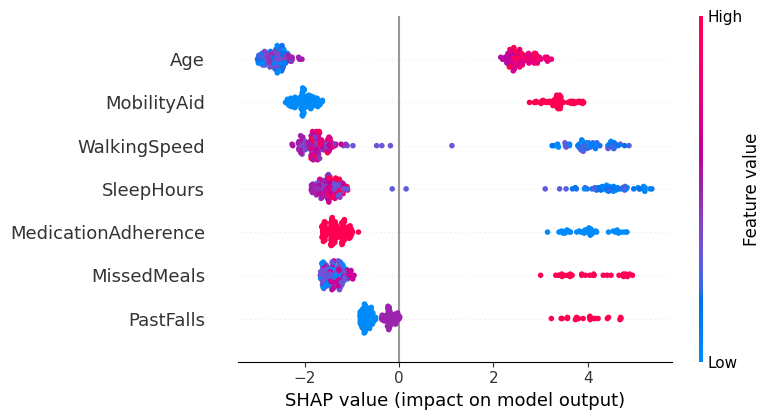

In [16]:
# SHAP summary plot
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns)


### SHAP Summary Plot

The SHAP summary plot helps us understand the overall impact of each feature on the model’s predictions. Each point represents a SHAP value for a specific feature and a particular sample.

- **Feature Distribution**: Features are listed along the y-axis, such as walking speed, missed meals, and sleep hours. The x-axis shows the SHAP values, which indicate how much each feature contributes to the prediction. Larger absolute values mean a stronger influence on the prediction.
- **Color Coding**: The color of the points indicates the feature's value: red for high values and blue for low values.

Key Observations:
- Features like **walking speed** and **missed meals** tend to have larger SHAP values, suggesting they have a significant impact on predicting fall risk.
- Features that cluster around a SHAP value of 0 may not influence the model as much.


##Feature Importance Plot

<ipython-input-17-b0d1cd3ae8fb>:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_scaled, plot_type="bar")


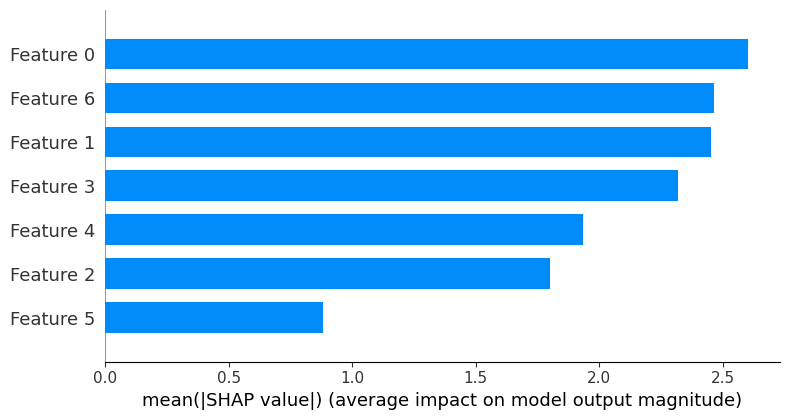

In [17]:
# SHAP feature importance plot
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar")


### SHAP Feature Importance Plot

The SHAP feature importance plot ranks the features by their average impact on the model’s predictions. The longer the bar, the more influential the feature.

- **What It Shows**: The chart tells us which features matter most when the model makes a decision.
- **Top Features**: Features like **walking speed** and **missed meals** are likely to have the longest bars, meaning they play a bigger role in determining whether someone is at risk of falling.

For example:
- A slower **walking speed** likely increases the fall risk, making it a high-impact feature.
- **Missed meals** might indicate poor health, contributing to higher fall risk as well.


##Visualize SHAP for Individual Predictions

In [18]:
# Visualize SHAP for a single prediction
shap.initjs()
shap.force_plot(shap_values[0])  # Visualize for the first test sample


### SHAP Force Plot (Individual Prediction)

The SHAP force plot is where we can get into the details of how each feature affects a single prediction. It shows how the features "push" the final prediction higher or lower.

- **Red and Blue Lines**: Features that push the fall risk prediction higher are shown in red, while those that lower it are in blue.
- **Feature Contributions**: The width of the line indicates how much each feature contributes to the prediction. A wider line means a larger influence.

For example:
- If **walking speed** is low for an individual, the plot will likely show a strong push toward higher fall risk (a red line).
- **Missed meals** or **sleep hours** might shift the prediction either up or down, depending on their values. Missing meals could increase fall risk, while better sleep might lower it.

This visualization helps us understand the **why** behind a particular prediction by showing the exact influence of each feature.


### SHAP Explanation of Fall Risk Prediction

- **SHAP Summary Plot**: The summary plot reveals how each feature impacts the model's predictions. Key features like walking speed and missed meals appear to be the most influential.
- **SHAP Feature Importance Plot**: This plot ranks the features, and it’s clear that walking speed and missed meals play a major role in predicting fall risk.
- **SHAP Force Plot**: This plot breaks down an individual prediction, showing how each feature pushes the prediction higher or lower. For example, a low walking speed will likely increase the fall risk, while better sleep might lower it.

Together, these SHAP plots provide us with a deeper understanding of the model's behavior and allow us to interpret the factors driving predictions for fall risk in elderly care.


#Model Deployment

##Installing Required Library

In [19]:
!pip install joblib


##Saving the Model Using Joblib

In [20]:
import joblib

# Save the trained model to a file
joblib.dump(model, 'elder_safe_fall_risk_model.joblib')


['elder_safe_fall_risk_model.joblib']

Saving the Scaler (for consistency during future predictions)

In [21]:
# Save the scaler used to scale the features
joblib.dump(scaler, 'scaler.joblib')


['scaler.joblib']

##Loading the Model and Scaler for Future Use

In [23]:
# Load the model from the saved file
loaded_model = joblib.load('elder_safe_fall_risk_model.joblib')

# Load the scaler
loaded_scaler = joblib.load('scaler.joblib')

# Now we can make predictions using the loaded model and scaler
